# Ordinal Logit/Proportional Odds Model

##### Model Summary:
An ordered logistic regression model is used when the outcome variable is categorical, and the order of those categories matter. For example, this model may be used to investigate what factors contribute to a customer feeling Unsatisfied, Netural, or Satisfied toward a product, or determine if a movie is likely to receive a 1-5 score on a 5-star rating system.

##### Dataset:
The IBM HR Analytics Employee Attrition & Performance dataset can be found at https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-datase. The site also includes a data dictionary.

##### Problem Statement:
Due to changes in the job market, IBM wants to conduct an analysis to help them better retain their existing employees. The Human Resources team has asked you to identify trends between employees and their work satisfaction level.

In [1]:
# import packages
#!pip install pandas
import pandas as pd
from pandas.api.types import CategoricalDtype
import os
import numpy as np

# stats packages 
import scipy.stats as stats
#!pip install statsmodels
import statsmodels.stats.api as sms
from scipy.stats import normaltest # uses D’Agostino test for normality
from scipy.stats import wilcoxon
from statsmodels.miscmodels.ordinal_model import OrderedModel # https://www.statsmodels.org/dev/generated/statsmodels.miscmodels.ordinal_model.OrderedModel.html

# data viz
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns

os.getcwd()

'C:\\Users\\18594\\Ordered_Logit_Propotional_Odds_Model'

### Import Data and Exploratory Data Analysis

In [2]:
# import data
df = pd.read_csv('C:\\Users\\18594\\Ordered_Logit_Propotional_Odds_Model\\HR_Employee_Attrition.csv')

# Since we are only looking at studying current employees, you will want to filter the data down to where Attrition=0
df = df.loc[df['Attrition'] == 'No']

# Creat numerical representation of the the following categorical variables
df['isFemale'] = np.where(df['Gender']=='Female',1,0) # 1 = female; 0 = male
df['OverTime_Binary'] = np.where(df['OverTime']=='Yes',1,0) # 1 = ye - works over time; 0 = no - does not work overt time

# preview data
print("Shape of data frame is:",df.shape)
df.head()

Shape of data frame is: (1233, 37)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,isFemale,OverTime_Binary
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,8,3,3,8,7,3,0,1,1
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,1,6,3,3,2,2,2,2,0,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,0,8,2,2,7,7,3,6,0,0
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,3,12,3,2,1,0,0,0,1,1


In [3]:
# check data types
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

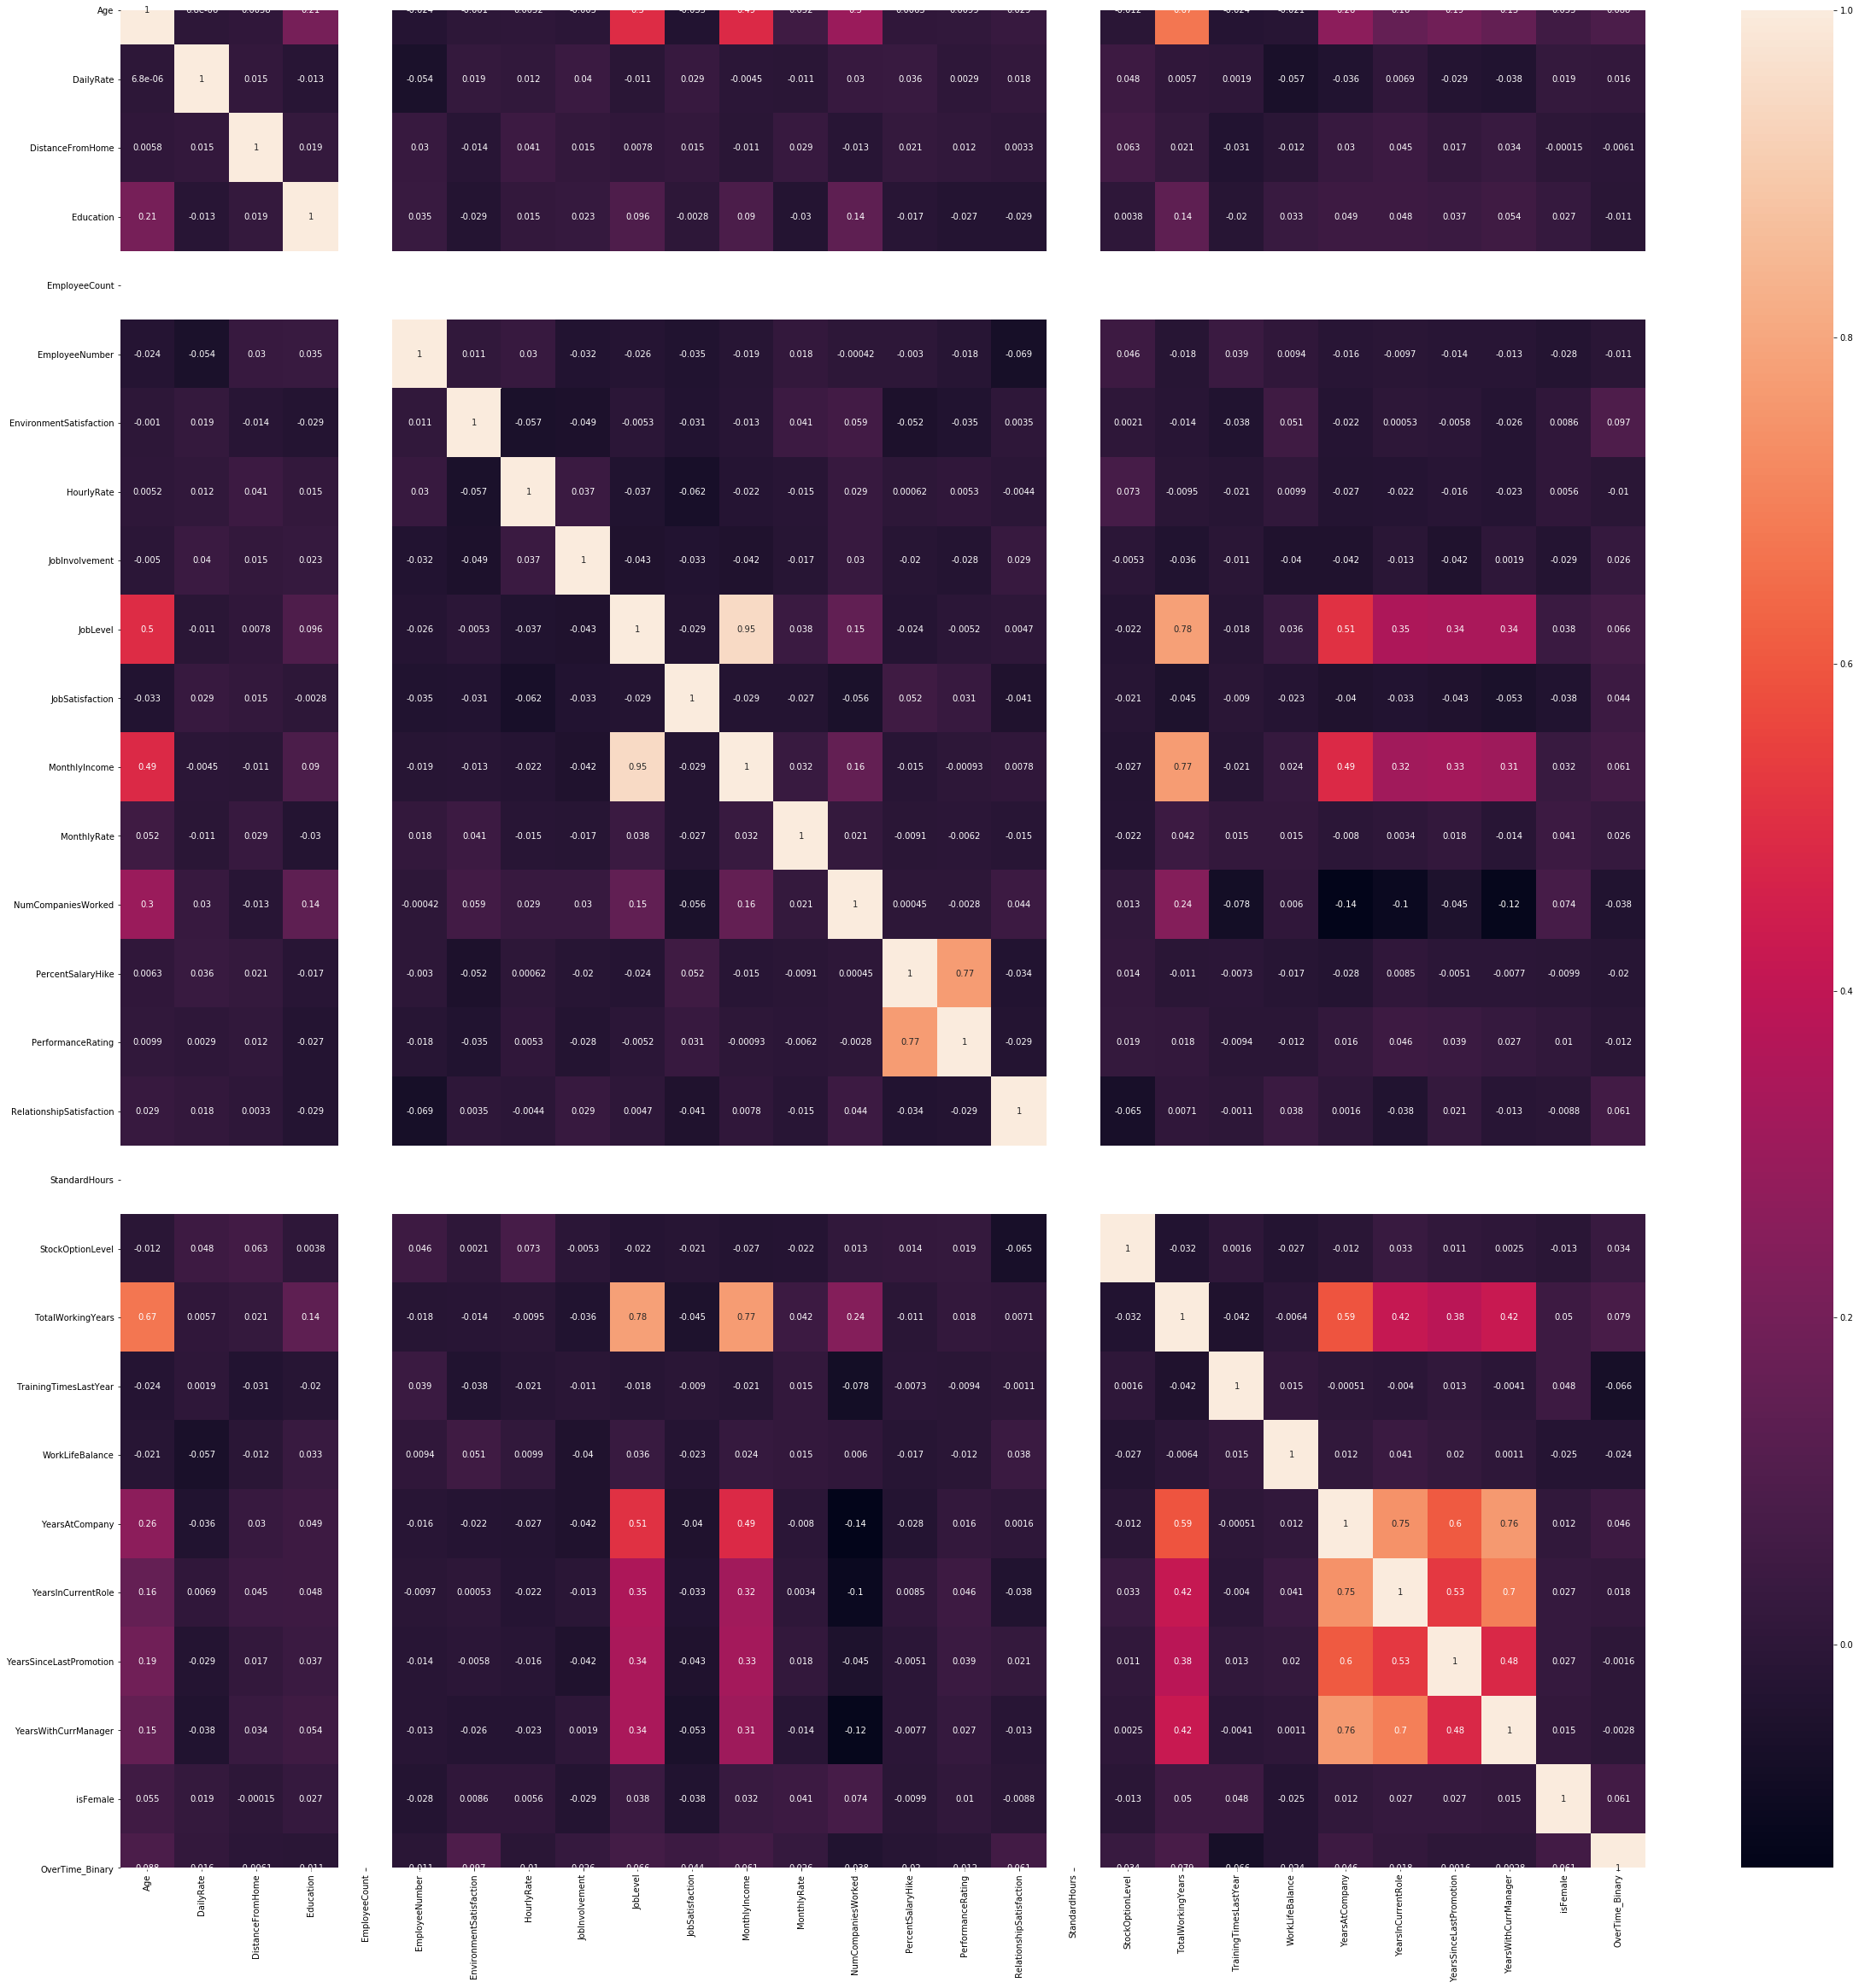

In [4]:
# see which fields may be highly correlated with job satisfaction
corr_matrix = df.corr()
plt.figure(figsize = (40,40)) # set size of heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [5]:
#Plot correlation matrix in a table view
df.corr()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,isFemale,OverTime_Binary
Age,1.000000,0.000007,0.005828,0.208739,NaN,-0.024071,-0.001000,0.005158,-0.005037,0.497797,...,-0.012452,0.672753,-0.024100,-0.021222,0.264745,0.158121,0.190892,0.154146,0.055353,0.087661
DailyRate,0.000007,1.000000,0.015425,-0.013103,NaN,-0.053613,0.019345,0.012215,0.040008,-0.010678,...,0.048172,0.005735,0.001945,-0.057386,-0.036447,0.006929,-0.029210,-0.038031,0.018688,0.016266
DistanceFromHome,0.005828,0.015425,1.000000,0.019373,NaN,0.029550,-0.014166,0.040857,0.014510,0.007809,...,0.062549,0.020947,-0.030805,-0.012445,0.029983,0.044839,0.016516,0.033575,-0.000153,-0.006125
Education,0.208739,-0.013103,0.019373,1.000000,NaN,0.034885,-0.029207,0.015267,0.023233,0.095539,...,0.003809,0.140810,-0.020184,0.032791,0.048644,0.047987,0.037161,0.053890,0.026652,-0.011013
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeNumber,-0.024071,-0.053613,0.029550,0.034885,NaN,1.000000,0.010649,0.029795,-0.031568,-0.025655,...,0.045845,-0.018282,0.038853,0.009447,-0.016292,-0.009714,-0.013578,-0.013258,-0.028100,-0.010668
EnvironmentSatisfaction,-0.001000,0.019345,-0.014166,-0.029207,NaN,0.010649,1.000000,-0.056943,-0.048973,-0.005309,...,0.002085,-0.013539,-0.038144,0.051394,-0.021621,0.000527,-0.005834,-0.025595,0.008612,0.096733
HourlyRate,0.005158,0.012215,0.040857,0.015267,NaN,0.029795,-0.056943,1.000000,0.036972,-0.037420,...,0.072647,-0.009520,-0.021362,0.009875,-0.027368,-0.021918,-0.015675,-0.023118,0.005591,-0.009978
JobInvolvement,-0.005037,0.040008,0.014510,0.023233,NaN,-0.031568,-0.048973,0.036972,1.000000,-0.042686,...,-0.005347,-0.036390,-0.011135,-0.039510,-0.042243,-0.012526,-0.041577,0.001949,-0.028668,0.025826
JobLevel,0.497797,-0.010678,0.007809,0.095539,NaN,-0.025655,-0.005309,-0.037420,-0.042686,1.000000,...,-0.021659,0.781068,-0.018481,0.035580,0.510764,0.349929,0.340457,0.342387,0.038215,0.066492


##### In this dataset, employees rank their JobSatisfaction is based on the following statements:

1. I am highly dissatisfied
2. I am dissatisfied
3. I am satisfied
4. I am highly satisfied

In [6]:
# Define Satisfaction categories as ordered categorical data dtypes from highly dissatisfied (1) being lowest rank to highly satisfied (4) being the highest rank
# https://analyticsindiamag.com/a-complete-tutorial-on-ordinal-regression-in-python/
cat_type_ordered = CategoricalDtype(categories=[1,2,3,4], ordered=True)
df["JobSatisfaction"] = df["JobSatisfaction"].astype(cat_type_ordered)
df["RelationshipSatisfaction"] = df["RelationshipSatisfaction"].astype(cat_type_ordered)
df["EnvironmentSatisfaction"] = df["EnvironmentSatisfaction"].astype(cat_type_ordered)

# identify binary categorical variables as a non-ordered categorical variable
# note ordered = False parameter that tells us that in these order does not matter
cat_type_non_ordered = CategoricalDtype(categories=[0,1], ordered=False)
df['isFemale'] = df['isFemale'].astype(cat_type_non_ordered)
df['OverTime_Binary'] = df['OverTime_Binary'].astype(cat_type_non_ordered)

# convert other dtypes as needed


As we plot the spread of JobSatisfaction, it seems most people are satisfied overall in their role - this is great news for us! But, there are a considerable number of employees who have a job satisfaction rating of 1 or 2. These may be at a heightened risk of leaving the company, so we want to dive deeper.


Text(0.5, 1.0, 'Score Distribution')

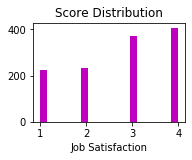

In [7]:
plt.subplot(222)
plt.hist(df['JobSatisfaction'],bins=20,color='m')
plt.xlabel('Job Satisfaction')
plt.title('Score Distribution')

In [8]:
# Number of people who provided each response
df['JobSatisfaction'].value_counts()

4    407
3    369
2    234
1    223
Name: JobSatisfaction, dtype: int64

# Model Setup

In [29]:
logit = OrderedModel(df['JobSatisfaction'], # target variable
                        df[['YearsSinceLastPromotion', 'NumCompaniesWorked', 'isFemale', 'OverTime_Binary',
                           'DistanceFromHome','TotalWorkingYears','PercentSalaryHike','HourlyRate','YearsWithCurrManager']], # independent variables #'TrainingTimesLastYear', 'YearsAtCompany', 
                        distr='logit') # model distribution
 
results = logit.fit(method='bfgs')
results.summary()

Optimization terminated successfully.
         Current function value: 1.342820
         Iterations: 30
         Function evaluations: 34
         Gradient evaluations: 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        JobSatisfaction   Log-Likelihood:                -1655.7
Model:                   OrderedModel   AIC:                             3335.
Method:            Maximum Likelihood   BIC:                             3397.
Date:                Mon, 05 Dec 2022                                         
Time:                        23:17:44                                         
No. Observations:                1233                                         
Df Residuals:                    1221                                         
Df Model:                          12                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
YearsSinceLastPromotion    -0.0106      0.019     -0.569      0.569      -0.047       0.026
NumCompaniesWorked         -0.0386      0.022     -1.740      0.082      -0.082       0.005
isFemale                   -0.1249      0.105     -1.187      0.235      -0.331       0.081
OverTime_Binary             0.2318      0.125      1.855      0.064      -0.013       0.477
DistanceFromHome            0.0040      0.006      0.619      0.536      -0.009       0.017
TotalWorkingYears          -0.0020      0.008     -0.256      0.798      -0.018       0.014
PercentSalaryHike           0.0277      0.014      1.936      0.053      -0.000       0.056
HourlyRate                 -0.0054      0.003     -2.104      0.035      -0.010      -0.000
YearsWithCurrManager       -0.0230      0.018     -1.304      0.192      -0.058       0.012
1/2                        -1.6731      0.307     -5.452      0.000      -2.275      -1.072
2/3                        -0.0083      0.061     -0.135      0.892      -0.128       0.112
3/4                         0.2271      0.046      4.884      0.000       0.136       0.318
===========================================================================================
"""

In [30]:
# calculate odds ratios for interpretation
# https://www.andrewvillazon.com/logistic-regression-python-statsmodels/#calculating-odds-ratios,≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥≥ 
odds_ratios = pd.DataFrame(
    {
        "Odds Ratios For Each Variable": results.params,
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                         Odds Ratios For Each Variable
YearsSinceLastPromotion                       0.989497
NumCompaniesWorked                            0.962152
isFemale                                      0.882580
OverTime_Binary                               1.260816
DistanceFromHome                              1.004000
TotalWorkingYears                             0.997953
PercentSalaryHike                             1.028049
HourlyRate                                    0.994653
YearsWithCurrManager                          0.977285
1/2                                           0.187669
2/3                                           0.991748
3/4                                           1.254937
